# Моделирование №2

### Условие
Смоделировать зоновую структуру одномерного кристалла по модели Кронига–Пенни и проследить изменение ширины запрещённых зон для трёх случаев:

- электрон совершенно свободен (U = 0),
- электрон заперт внутри одной потенциальной ямы (стенки непроницаемы, очень большой U),
- промежуточные значения U.

В модели используем потенциал с периодом `c`, шириной ям `a` (внутри ямы `U=0`, вне ямы `U=U0`). В численной реализации дискретизируем единичную ячейку и применим краевые условия Блоха:
 > ψ(x + c) = exp(i k c) ψ(x).

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Параметры геометрии
a = 1.0
c_over_a = 2.0
c = c_over_a * a
b = c - a

In [12]:
# Аналитическая форма для прямоугольного потенциала
def F_rect(alpha_a, U0, c_over_a):
    """
    Вычисление функции F(ε) для прямоугольного потенциала Кронига–Пенни.
    - При ε < U0: κ = sqrt(U0 − ε),
      F(ε) = cos(αa) · cosh(κb) + ((κ² − α²) / (2ακ)) · sin(αa) · sinh(κb).
    - При ε ≥ U0: β = sqrt(ε − U0),
      F(ε) = cos(αa) · cos(βb) − ((α² + β²) / (2αβ)) · sin(αa) · sin(βb).
    """
    a = 1.0
    c = c_over_a * a
    b = c - a

    eps = alpha_a**2
    alpha = alpha_a

    F = np.empty_like(alpha_a, dtype=float)

    # Область ε < U0
    mask_below = eps < U0
    if np.any(mask_below):
        eps_b = eps[mask_below]
        alpha_b = alpha[mask_below]
        kappa_b = np.sqrt(U0 - eps_b)

        denom = 2 * alpha_b * kappa_b
        small = 1e-12
        denom = np.where(np.abs(denom) < small, small, denom)

        F_b = (np.cos(alpha_b * a) * np.cosh(kappa_b * b) +
               (kappa_b**2 - alpha_b**2) / denom *
               np.sin(alpha_b * a) * np.sinh(kappa_b * b))
        F[mask_below] = F_b

    # Область ε >= U0
    mask_above = ~mask_below
    if np.any(mask_above):
        eps_a = eps[mask_above]
        alpha_a2 = alpha[mask_above]
        beta_a = np.sqrt(eps_a - U0)

        denom = 2 * alpha_a2 * beta_a
        small = 1e-12
        denom = np.where(np.abs(denom) < small, small, denom)

        F_a = (np.cos(alpha_a2 * a) * np.cos(beta_a * b) -
               (alpha_a2**2 + beta_a**2) / denom *
               np.sin(alpha_a2 * a) * np.sin(beta_a * b))
        F[mask_above] = F_a

    return F



In [13]:
# Поиск зон: |F(ε)| ≤ 1
def find_bands(alpha_a, F_val):
    """
    Поиск интервалов разрешённых энергетических зон по критерию |F(ε)| ≤ 1.
    - |F(ε)| ≤ 1 => существуют решения с волновым числом k (условие Блоха: cos(kc) = F(ε)).
    """
    # Разрешённые зоны там, где |F(ε)| ≤ 1
    mask = np.abs(F_val) <= 1.0
    bands = []

    N = len(alpha_a)
    i = 0
    while i < N:
        if mask[i]:
            start = i
            while i < N and mask[i]:
                i += 1
            end = i - 1

            alpha_min = alpha_a[start]
            alpha_max = alpha_a[end]

            E_min = alpha_min**2
            E_max = alpha_max**2
            bands.append((E_min, E_max))
        else:
            i += 1

    return bands



In [14]:
# Информация о зонах
def print_band_info(label, bands, n_show=3):
    """
    Вывод первых n_show разрешённых зон и ширины запрещённых промежутков между ними.
    - Зона i: E ∈ [E_min, E_max].
    - Запрещённая зона между i и i+1: ΔE = E_{i+1,min} − E_{i,max}.
    """
    print(f"\n=== {label} ===")
    if len(bands) == 0:
        print("Разрешённых зон не найдено на выбранном диапазоне энергий.")
        return

    for i, (Emin, Emax) in enumerate(bands[:n_show], start=1):
        print(f"Разрешённая зона {i}: E ∈ [{Emin:.3f}, {Emax:.3f}]")

    n_bands_to_consider = min(len(bands), n_show)
    for i in range(n_bands_to_consider - 1):
        gap_min = bands[i][1]
        gap_max = bands[i + 1][0]
        print(
            f"Запрещённая зона между {i+1} и {i+2}: "
            f"ΔE = {gap_max - gap_min:.3f}, E ∈ [{gap_min:.3f}, {gap_max:.3f}]"
        )



In [15]:
alpha_a = np.linspace(1e-3, 20.0, 20000)


=== U0 = 0 (совершенно свободный электрон) ===
Разрешённая зона 1: E ∈ [0.000, 400.000]


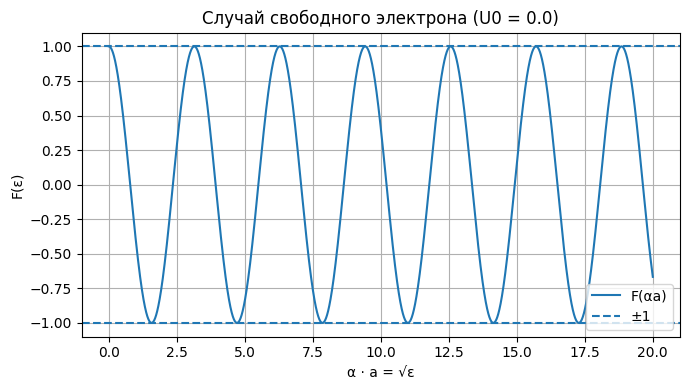

In [16]:
# Случай U0 = 0 (свободный электрон)
U_free = 0.0
F_free = F_rect(alpha_a, U_free, c_over_a)

plt.figure(figsize=(7, 4))
plt.title(f"Случай свободного электрона (U0 = {U_free})")
plt.plot(alpha_a, F_free, label="F(αa)")
plt.axhline(1.0, linestyle="--", label="±1")
plt.axhline(-1.0, linestyle="--")
plt.xlabel("α · a = √ε")
plt.ylabel("F(ε)")
plt.grid(True)
plt.legend()
plt.tight_layout()

bands_free = find_bands(alpha_a, F_free)
print_band_info("U0 = 0 (совершенно свободный электрон)", bands_free, n_show=3)



=== U0 = 20.0 (почти непроницаемые стенки) ===
Разрешённая зона 1: E ∈ [4.499, 4.683]
Разрешённая зона 2: E ∈ [15.524, 17.497]
Разрешённая зона 3: E ∈ [24.562, 32.353]
Разрешённая зона 4: E ∈ [34.328, 48.944]
Разрешённая зона 5: E ∈ [51.208, 71.048]
Запрещённая зона между 1 и 2: ΔE = 10.841, E ∈ [4.683, 15.524]
Запрещённая зона между 2 и 3: ΔE = 7.064, E ∈ [17.497, 24.562]
Запрещённая зона между 3 и 4: ΔE = 1.975, E ∈ [32.353, 34.328]
Запрещённая зона между 4 и 5: ΔE = 2.264, E ∈ [48.944, 51.208]


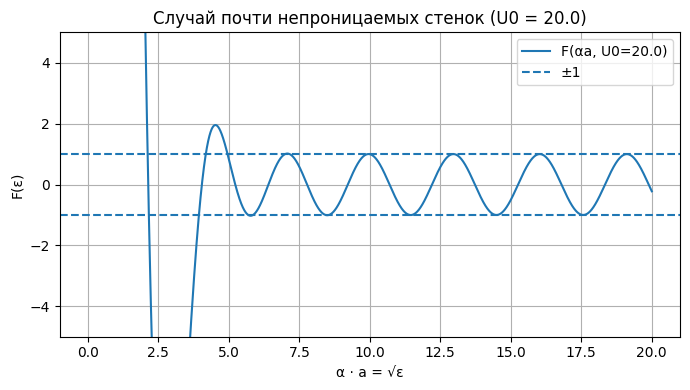

In [17]:
# Случай с большим барьером U0
U_hard = 20.0
F_hard = F_rect(alpha_a, U_hard, c_over_a)

plt.figure(figsize=(7, 4))
plt.title(f"Случай почти непроницаемых стенок (U0 = {U_hard})")
plt.plot(alpha_a, F_hard, label=f"F(αa, U0={U_hard})")
plt.axhline(1.0, linestyle="--", label="±1")
plt.axhline(-1.0, linestyle="--")
plt.xlabel("α · a = √ε")
plt.ylabel("F(ε)")
plt.grid(True)
plt.legend()
plt.ylim(-5, 5)
plt.tight_layout()

bands_hard = find_bands(alpha_a, F_hard)
print_band_info(f"U0 = {U_hard} (почти непроницаемые стенки)", bands_hard, n_show=5)



=== U0 = 0.1 ===
Разрешённая зона 1: E ∈ [0.050, 2.484]
Разрешённая зона 2: E ∈ [2.550, 22.241]
Разрешённая зона 3: E ∈ [22.269, 61.717]
Разрешённая зона 4: E ∈ [61.748, 120.934]
Запрещённая зона между 1 и 2: ΔE = 0.067, E ∈ [2.484, 2.550]
Запрещённая зона между 2 и 3: ΔE = 0.028, E ∈ [22.241, 22.269]
Запрещённая зона между 3 и 4: ΔE = 0.031, E ∈ [61.717, 61.748]

=== U0 = 5.0 ===
Разрешённая зона 1: E ∈ [2.005, 3.254]
Разрешённая зона 2: E ∈ [6.406, 12.208]
Разрешённая зона 3: E ∈ [12.824, 24.256]
Разрешённая зона 4: E ∈ [25.281, 41.939]
Запрещённая зона между 1 и 2: ΔE = 3.152, E ∈ [3.254, 6.406]
Запрещённая зона между 2 и 3: ΔE = 0.616, E ∈ [12.208, 12.824]
Запрещённая зона между 3 и 4: ΔE = 1.025, E ∈ [24.256, 25.281]

=== U0 = 20.0 ===
Разрешённая зона 1: E ∈ [4.499, 4.683]
Разрешённая зона 2: E ∈ [15.524, 17.497]
Разрешённая зона 3: E ∈ [24.562, 32.353]
Разрешённая зона 4: E ∈ [34.328, 48.944]
Запрещённая зона между 1 и 2: ΔE = 10.841, E ∈ [4.683, 15.524]
Запрещённая зона между 

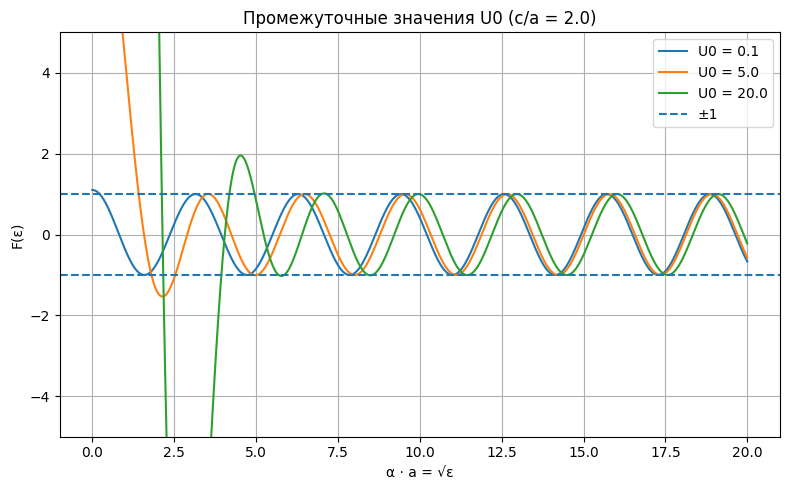

In [18]:
# Промежуточные значения U0
U_list = [0.1, 5.0, 20.0]

plt.figure(figsize=(8, 5))
Y_MAX = 5

for U0 in U_list:
    F_val = F_rect(alpha_a, U0, c_over_a)
    plt.plot(alpha_a, F_val, label=f"U0 = {U0}")

plt.axhline(1.0, linestyle="--", label="±1")
plt.axhline(-1.0, linestyle="--")
plt.xlabel("α · a = √ε")
plt.ylabel("F(ε)")
plt.title(f"Промежуточные значения U0 (c/a = {c_over_a})")
plt.grid(True)
plt.legend()
plt.ylim(-Y_MAX, Y_MAX)
plt.tight_layout()

for U0 in U_list:
    F_val = F_rect(alpha_a, U0, c_over_a)
    bands = find_bands(alpha_a, F_val)
    print_band_info(f"U0 = {U0}", bands, n_show=4)

plt.show()